<a href="https://colab.research.google.com/github/meowster99/news-sentiment-analysis/blob/bert-anaylsis/BERT_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.8 MB/s 
     |████████████████████████████████| 7.6 MB 42.5 MB/s 
     |████████████████████████████████| 163 kB 57.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertConfig, TFBertModel, BertTokenizer, TFBertForSequenceClassification, TFDistilBertModel, TFAutoModelForSequenceClassification

import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import pad_sequences


SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!cat /proc/meminfo

MemTotal:       13297220 kB
MemFree:         7888636 kB
MemAvailable:   10270456 kB
Buffers:           68032 kB
Cached:          2156324 kB
SwapCached:            0 kB
Active:           486532 kB
Inactive:        4529808 kB
Active(anon):      15936 kB
Inactive(anon):  2420556 kB
Active(file):     470596 kB
Inactive(file):  2109252 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1156 kB
Writeback:             0 kB
AnonPages:       2792000 kB
Mapped:           727848 kB
Shmem:             11548 kB
KReclaimable:      87100 kB
Slab:             133016 kB
SReclaimable:      87100 kB
SUnreclaim:        45916 kB
KernelStack:        4960 kB
PageTables:        60448 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648608 kB
Committed_AS:    4064876 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       53500 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
class time_for_epoch(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


# BERT For Dataset A: Financial News Dataset

## Loading News Data

In [ ]:
# Read Train and Test data
#import the train and test files for financial news
fnews_Xtrain = pd.read_csv('fnews_Xtrain.csv')
fnews_Xtest = pd.read_csv('fnews_Xtest.csv')
fnews_ytrain = pd.read_csv('fnews_ytrain.csv')
fnews_ytest = pd.read_csv('fnews_ytest.csv')

# drop the first column for all the train and test sets
fnews_Xtrain.drop(columns=fnews_Xtrain.columns[0], axis=1, inplace=True)
fnews_ytrain.drop(columns=fnews_ytrain.columns[0], axis=1, inplace=True)
fnews_Xtest.drop(columns=fnews_Xtest.columns[0], axis=1, inplace=True)
fnews_ytest.drop(columns=fnews_ytest.columns[0], axis=1, inplace=True)

#check the respective shape of the train and test sets
print('Xtrain:',fnews_Xtrain.shape, 'ytrain:' ,fnews_ytrain.shape)
print('Xtest:',fnews_Xtest.shape, 'ytest:' ,fnews_ytest.shape)

Xtrain: (3876, 1) ytrain: (3876, 1)
Xtest: (970, 1) ytest: (970, 1)


In [ ]:
fnews_Xtrain.head()

,News
0,"['russia', 'raisio', 's', 'food', 'division', ..."
1,"['operator', 'need', 'learn', 'use', 'device',..."
2,"['company', 'expects', 'net', 'sale', 'half', ..."
3,"['bridge', 'km', 'long', 'located', 'anasmotet..."
4,"['nokia', 'capcom', 'announced', 'resident', '..."


## Preparing Data for BERT

In [ ]:
# set the maximum length of sentences for BERT
MAX_LEN = max([len(x) for x in fnews_Xtrain["News"]])

# some dataset handling
fnews_Xtrain['News'] = fnews_Xtrain['News'].apply(eval)
fnews_Xtest['News'] = fnews_Xtest['News'].apply(eval)

# preparing the data for BERT
def create_attention_masks(df):
    # BERT requires special tokens at the beginning and end of each sentence for it to work properly
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    input_ids = []
    token_type_ids = []
    attention_masks = []
    for headline in df:
        tokenized_texts = tokenizer.encode_plus(" ".join(headline),
                                                    add_special_tokens=True,
                                                    max_length=MAX_LEN,
                                                    padding='max_length',
                                                    truncation=True,
                                                    return_attention_mask=True)
        input_ids.append(tokenized_texts['input_ids'])
        token_type_ids.append(tokenized_texts['token_type_ids'])
        attention_masks.append(tokenized_texts['attention_mask'])
    return input_ids, token_type_ids, attention_masks

# mapping the classes to a numeric representation
train_labels = fnews_ytrain['Class'].map({'neutral':1, 'positive': 2, 'negative': 0}).values
test_labels = fnews_ytest['Class'].map({'neutral':1, 'positive': 2, 'negative': 0}).values

# split into train, val and test datasets and check the shapes
train_input_ids, train_tokens, train_attention_masks = create_attention_masks(fnews_Xtrain['News'])
test_input_ids, test_tokens, test_attention_masks = create_attention_masks(fnews_Xtest['News'])
ttrain_input_ids, val_input_ids, ttrain_tokens, val_tokens, ttrain_attention_masks, val_attention_masks, ttrain_labels, val_labels  = train_test_split(train_input_ids, train_tokens, train_attention_masks, train_labels, test_size=0.2)
print('Train shape: ', len(ttrain_input_ids), len(ttrain_tokens), len(ttrain_attention_masks), len(ttrain_labels))
print('Val shape: ', len(val_input_ids), len(val_tokens), len(val_attention_masks), len(val_labels))
print('Test shape: ', len(test_input_ids), len(test_tokens), len(test_attention_masks), len(test_labels))

Train shape:  3100 3100 3100 3100
Val shape:  776 776 776 776
Test shape:  970 970 970 970


Taking a look at the Cosine Similarity between classes in the Financial News Dataset

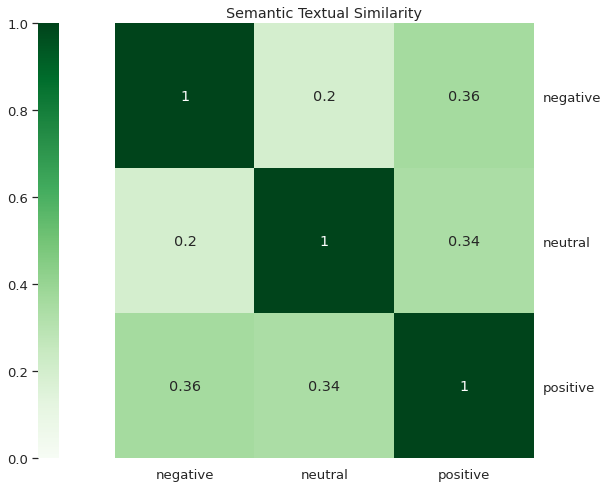

In [ ]:
# looking at the textual similarity
from sklearn.metrics.pairwise import cosine_similarity
import random

def plot_similarity(features, labels):
  """
  Plot a similarity matrix of the embeddings.
  Reference code taken from: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d
  """
  plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cosine_similarity(features), xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Greens", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

sentiments = ["negative", "neutral", "positive"]

# comparing a random sample from each
neg_samples = np.array(ttrain_input_ids)[ttrain_labels==0]
neu_samples = np.array(ttrain_input_ids)[ttrain_labels==1]
pos_samples = np.array(ttrain_input_ids)[ttrain_labels==2]
plot_similarity([
  neg_samples[random.randint(0, len(neg_samples)-1)], 
  neu_samples[random.randint(0, len(neu_samples)-1)], 
  pos_samples[random.randint(0, len(pos_samples)-1)]
  ], sentiments)

In [ ]:
NUM_CLASSES = 3
ttrain_inputs = tf.convert_to_tensor(ttrain_input_ids, dtype=tf.int32, name='input_ids')
val_inputs = tf.convert_to_tensor(val_input_ids, dtype=tf.int32, name='input_ids')
test_inputs = tf.convert_to_tensor(test_input_ids, dtype=tf.int32, name='input_ids')

ttrain_tokens = tf.convert_to_tensor(ttrain_tokens,dtype=tf.int32, name='token_ids')
val_tokens = tf.convert_to_tensor(val_tokens, dtype=tf.int32, name='token_ids')
test_tokens = tf.convert_to_tensor( test_tokens, dtype=tf.int32, name='token_ids')

ttrain_masks = tf.convert_to_tensor(ttrain_attention_masks, dtype=tf.int32, name='attention_masks')
val_masks = tf.convert_to_tensor(val_attention_masks, dtype=tf.int32, name='attention_masks')
test_masks = tf.convert_to_tensor(test_attention_masks, dtype=tf.int32, name='attention_masks')

# ttrain_labels = tf.convert_to_tensor(ttrain_labels)
# val_labels = tf.convert_to_tensor(val_labels)
# test_labels = tf.convert_to_tensor(test_labels)

ttrain_labels = tf.keras.utils.to_categorical(ttrain_labels, num_classes=NUM_CLASSES)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=NUM_CLASSES)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=NUM_CLASSES)


def map_to_dict(inputs, masks, tokens, labels):
    return {
        'input_ids': inputs,
        'attention_masks': masks,
        'token_ids': tokens,
    }, labels

BATCH_SIZE = 8
train_ds = tf.data.Dataset.from_tensor_slices((ttrain_inputs, ttrain_masks, ttrain_tokens, ttrain_labels)).map(map_to_dict).shuffle(len(ttrain_inputs)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_masks, val_tokens, val_labels)).map(map_to_dict).shuffle(len(val_inputs)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_inputs, test_masks, test_tokens, test_labels)).map(map_to_dict).shuffle(len(test_inputs)).batch(BATCH_SIZE)

In [ ]:
## Initialize pre-built BERT-based classifier from transformers
def create_base_model():
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    # tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 
    inputs = [ids, masks]
    config = BertConfig()
    config.output_hidden_states = False
    bert_model = TFAutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    # outputs = bert_model(input_ids=ids, attention_mask=masks, token_type_ids=tokens)
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model
epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
bert_model = create_base_model()
# bert_model = TFBertForSequenceClassification.from_pretrained(
#         'bert-base-uncased', num_labels=NUM_CLASSES)
bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics],
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'distilbert', 'activation_13']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_masks[0][0]']        
 fication)                      logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [ ]:
from datetime import datetime
from tensorflow.keras.callbacks import Callback
log_dir = "bert-distilled/fit/" + f'base-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

te = time_for_epoch()     

In [ ]:
base_model_history = bert_model.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds, 
                         callbacks=[tensorboard_callback, te, es]
                         )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['distilbert', 'vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_1 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]']        
 sification)                    logits=(None, 2),                                                 
                                 hidden_states=None                                         

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['token_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


388/388 [==============================] - 298s 724ms/step - loss: 0.9137 - accuracy: 0.6065 - precision: 0.6245 - recall: 0.5155 - val_loss: 0.8569 - val_accuracy: 0.6366 - val_precision: 0.6571 - val_recall: 0.6224
Epoch 2/10
388/388 [==============================] - 273s 704ms/step - loss: 0.8366 - accuracy: 0.6397 - precision: 0.6757 - recall: 0.5645 - val_loss: 0.8186 - val_accuracy: 0.6482 - val_precision: 0.6759 - val_recall: 0.5966
Epoch 3/10
388/388 [==============================] - 273s 703ms/step - loss: 0.7234 - accuracy: 0.6842 - precision: 0.7347 - recall: 0.6200 - val_loss: 0.7745 - val_accuracy: 0.6546 - val_precision: 0.7099 - val_recall: 0.5644
Epoch 4/10
388/388 [==============================] - 274s 707ms/step - loss: 0.6068 - accuracy: 0.7374 - precision: 0.7737 - recall: 0.6884 - val_loss: 0.8553 - val_accuracy: 0.6082 - val_precision: 0.6377 - val_recall: 0.5760
Epoch 5/10
388/388 [==============================] - 279s 719ms/step - loss: 0.5215 - accuracy: 0.

In [ ]:
def f1_score(precision, recall):
   return 2*((precision*recall)/(precision+recall))

print('Train F1 Score of last epoch: ', f1_score(0.8349,0.7845))
print('Val F1 Score of last epoch: ', f1_score(0.6134,0.6031))

Train F1 Score of last epoch:  0.8089157095220453
Val F1 Score of last epoch:  0.6082063953966297


In [ ]:
def plot_acc_loss_against_epoch(model, max_range, title1='', title2=''):
  plt.figure()
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Model Accuracy (Training)') if title1=='' else plt.title(title1)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper left')

  plt.figure()
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model Loss (Training)') if title2=='' else plt.title(title2)
  plt.ylabel('cross-entropy')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper right')
  
def plot_prec_recall_against_epoch(model, max_range, title1='', title2=''):
  plt.figure()
  plt.plot(model.history['precision'])
  plt.plot(model.history['val_precision'])
  plt.title('Model Precision (Training)') if title1=='' else plt.title(title1)
  plt.ylabel('precision')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper left')

  plt.figure()
  plt.plot(model.history['recall'])
  plt.plot(model.history['val_recall'])
  plt.title('Model Recall (Training)')  if title2=='' else plt.title(title2)
  plt.ylabel('Recall')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper right')

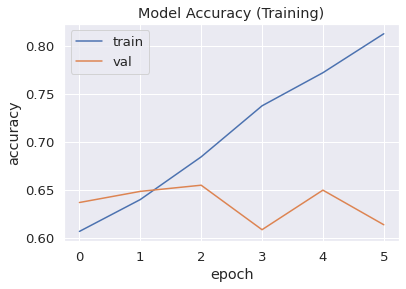

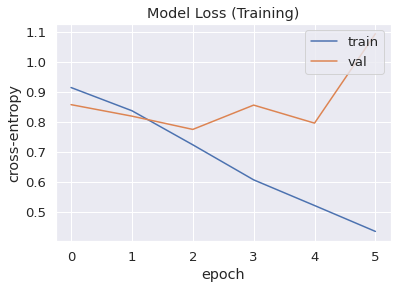

In [ ]:
plot_acc_loss_against_epoch(base_model_history, 6)

Model has a tendency to overfit and not reach convergence.

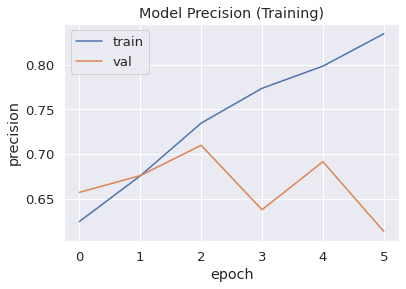

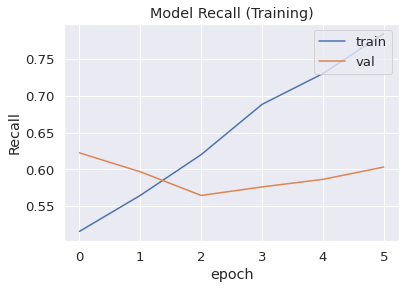

In [ ]:
plot_prec_recall_against_epoch(base_model_history, 6)

In [ ]:
print('Time for each epoch: ', sum(te.times)/len(te.times))

Time for each epoch:  277.876158952713


In [ ]:
bert_model.evaluate(test_ds)

122/122 [==============================] - 27s 218ms/step - loss: 0.7400 - accuracy: 0.6804 - precision: 0.7285 - recall: 0.6031


[0.7399803996086121,
 0.6804123520851135,
 0.7285180687904358,
 0.6030927896499634]

In [ ]:
print('Test F1 Score: ', f1_score(0.7285,0.6031))

Test F1 Score:  0.6598953890057074


In [ ]:
def print_all_results(model, model_history, te, predict=True):
  last_idx = len(model_history.history['precision'])-1
  print('Train F1 Score of last epoch: ', f1_score(model_history.history['precision'][last_idx],model_history.history['recall'][last_idx]))
  print('Val F1 Score of last epoch: ', f1_score(model_history.history['val_precision'][last_idx],model_history.history['val_recall'][last_idx]))
  print('Time for each epoch: ', sum(te.times)/len(te.times))
  if predict:
    preds = model.evaluate(test_ds)
    print('Test Prediction Results: ', preds)
    print('Test F1 Score: ', f1_score(preds[2],preds[3]))

## Using Base Bert Models - 'bert-base' and 'distilbert-base'

In [ ]:
## Initialize pre-built BERT-based classifier from transformers
def create_full_base_model():
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False
    # We are NOT using the Distilled Version in this case
    # We will also using the token_type_ids as inputs for this BERT Model
    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
bert_model_full = create_full_base_model()
bert_model_full.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics],
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_1 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

In [ ]:
log_dir = "bert-full/fit/" + f'base-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

te_full = time_for_epoch()      
bert_model_full_history = bert_model_full.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds, 
                         callbacks=[tensorboard_callback, te_full, es]
                         )

Epoch 1/10
388/388 [==============================] - 294s 712ms/step - loss: 0.7898 - accuracy: 0.6574 - precision: 0.7479 - recall: 0.5071 - val_loss: 0.6408 - val_accuracy: 0.7397 - val_precision: 0.8366 - val_recall: 0.5541
Epoch 2/10
388/388 [==============================] - 272s 702ms/step - loss: 0.5977 - accuracy: 0.7477 - precision: 0.7947 - recall: 0.6681 - val_loss: 0.5843 - val_accuracy: 0.7526 - val_precision: 0.7861 - val_recall: 0.7010
Epoch 3/10
388/388 [==============================] - 272s 700ms/step - loss: 0.4382 - accuracy: 0.8481 - precision: 0.8787 - recall: 0.8132 - val_loss: 0.5164 - val_accuracy: 0.8093 - val_precision: 0.8366 - val_recall: 0.7719
Epoch 4/10
388/388 [==============================] - 272s 702ms/step - loss: 0.2958 - accuracy: 0.9084 - precision: 0.9188 - recall: 0.8942 - val_loss: 0.5466 - val_accuracy: 0.8157 - val_precision: 0.8259 - val_recall: 0.8067
Epoch 5/10
388/388 [==============================] - 272s 702ms/step - loss: 0.1969 - a

In [ ]:
print('Train F1 Score of last epoch: ', f1_score(0.9601,0.9558))
print('Val F1 Score of last epoch: ', f1_score(0.8305,0.8209))

Train F1 Score of last epoch:  0.9579451745915757
Val F1 Score of last epoch:  0.825672096403052


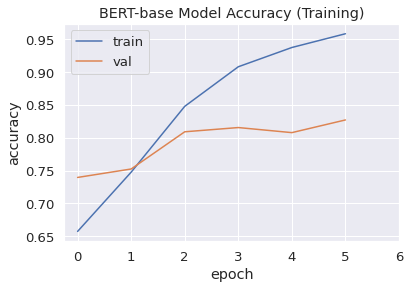

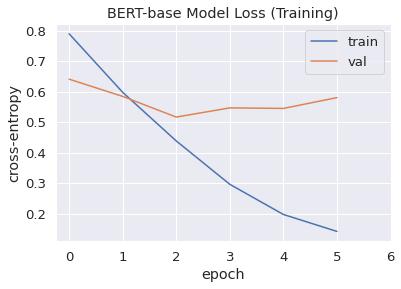

In [ ]:
plot_acc_loss_against_epoch(bert_model_full_history, 6,  title1='BERT-base Model Accuracy (Training)', title2='BERT-base Model Loss (Training)')

In [ ]:
plot_prec_recall_against_epoch(bert_model_full_history, 6, title1='BERT-base Model Precision (Training)', title2='BERT-base Model Recall (Training)')

In [ ]:
print('Time for each epoch: ', sum(te_full.times)/len(te_full.times))

In [ ]:
bert_model_full.evaluate(test_ds)

122/122 [==============================] - 27s 219ms/step - loss: 0.5829 - accuracy: 0.8093 - precision: 0.8245 - recall: 0.7701


[0.5829474329948425,
 0.8092783689498901,
 0.8245033025741577,
 0.7701030969619751]

In [ ]:
print('Test F1 Score: ', f1_score(0.8245,0.7701))

Test F1 Score:  0.7963720682302772


Bert-base appears to work better than DistilledBERT. 

## Modifying BERT-base to prevent overfitting & to improve performance

We will do the following to improve the performance of BERT. 

First, add a dropout layer to prevent overfitting.

Second, test different MAX_LEN on the dataset to see if truncating the sentences earlier improves the model performance.

Third, apply hyperparameter tuning for the learning_rate, and batch_size.

Fourth, use backtranslation to upsample the dataset due to the uneven class distribution.

Fifth, unfreeze the last layer and modify BERT.

### Adding a dropout layer

In [ ]:
def create_modified_model():
    """ Adding a dropout layer to prevent overfitting. """
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dropout(0.2)(embedded_layer)
    outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
bert_model_dropout = create_modified_model()
bert_model_dropout.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics],
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_2 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

In [ ]:
log_dir = "bert-dropout/fit/" + f'base-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

te_dropout = time_for_epoch()      
bert_model_dropout_history = bert_model_dropout.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds, 
                         callbacks=[tensorboard_callback, te_dropout, es]
                         )

Epoch 1/10
388/388 [==============================] - 297s 719ms/step - loss: 0.9855 - accuracy: 0.5890 - precision: 0.7371 - recall: 0.2071 - val_loss: 0.8169 - val_accuracy: 0.7178 - val_precision: 0.7968 - val_recall: 0.5863
Epoch 2/10
388/388 [==============================] - 281s 723ms/step - loss: 0.7853 - accuracy: 0.7094 - precision: 0.7820 - recall: 0.6065 - val_loss: 0.6617 - val_accuracy: 0.7990 - val_precision: 0.8516 - val_recall: 0.7101
Epoch 3/10
388/388 [==============================] - 287s 740ms/step - loss: 0.6692 - accuracy: 0.7468 - precision: 0.8173 - recall: 0.6926 - val_loss: 0.6225 - val_accuracy: 0.8144 - val_precision: 0.8455 - val_recall: 0.7758
Epoch 4/10
388/388 [==============================] - 276s 710ms/step - loss: 0.5576 - accuracy: 0.7877 - precision: 0.8696 - recall: 0.7484 - val_loss: 0.6577 - val_accuracy: 0.7990 - val_precision: 0.8119 - val_recall: 0.7732
Epoch 5/10
388/388 [==============================] - 272s 700ms/step - loss: 0.4850 - a

In [ ]:
print_all_results(bert_model_dropout, bert_model_dropout_history, te_dropout)

Train F1 Score of last epoch:  0.880848829269317
Val F1 Score of last epoch:  0.8318122472977839
Time for each epoch:  282.82676526904106
122/122 [==============================] - 26s 212ms/step - loss: 0.7140 - accuracy: 0.8062 - precision: 0.8263 - recall: 0.7845
Test Prediction Results:  [0.7139534950256348, 0.8061855435371399, 0.8262757658958435, 0.7845360636711121]
Test F1 Score:  0.8048651307173843


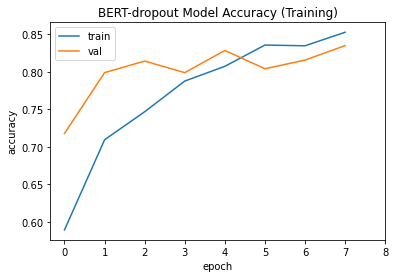

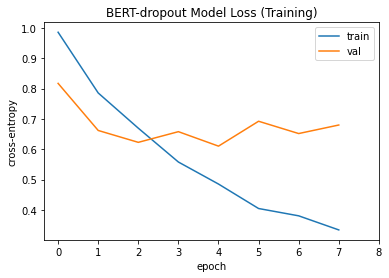

In [ ]:
plot_acc_loss_against_epoch(bert_model_dropout_history, max_range=9, title1='BERT-dropout Model Accuracy (Training)', title2='BERT-dropout Model Loss (Training)')

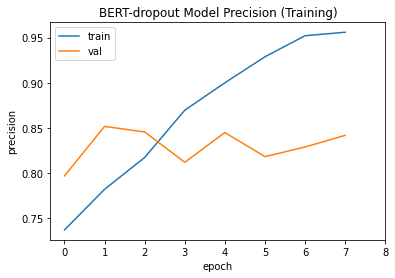

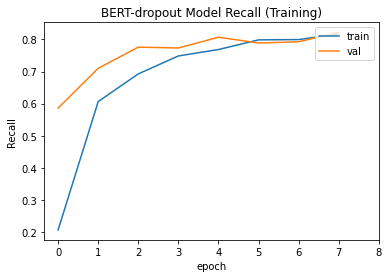

In [ ]:
plot_prec_recall_against_epoch(bert_model_dropout_history, max_range=9, title1='BERT-dropout Model Precision (Training)', title2='BERT-dropout Model Recall (Training)')

The addition of the dropout layer has reduced the overfitting of the model, but increased the number of epochs/ time until convergence.

### Effect of MAX_LEN on training

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def create_bert_inputs(df, max_len):
  """ 
  Creates bert features as in create_attention_masks(), 
  but with the addition of the parameter max_len to adjust the truncation/padding of sentences.
  """
    input_ids = []
    token_type_ids = []
    attention_masks = []
    for headline in df:
        tokenized_texts = tokenizer.encode_plus(" ".join(headline),
                                                    add_special_tokens=True,
                                                    max_length=max_len,
                                                    padding='max_length',
                                                    truncation=True,
                                                    return_attention_mask=True)
        input_ids.append(tokenized_texts['input_ids'])
        token_type_ids.append(tokenized_texts['token_type_ids'])
        attention_masks.append(tokenized_texts['attention_mask'])
    return input_ids, token_type_ids, attention_masks

In [ ]:
def generate_custom_ds(batch_size, max_len):
  """
  Creates the train_ds and val_ds used for training with the updated max_len value.
  """
    hp_modified_train_input_ids, hp_modified_train_tokens, hp_modified_train_attention_masks = create_bert_inputs(fnews_Xtrain['News'], max_len)
    hp_modified_ttrain_input_ids, hp_modified_val_input_ids, hp_modified_ttrain_tokens, hp_modified_val_tokens, hp_modified_ttrain_attention_masks, hp_modified_val_attention_masks, hp_modified_ttrain_labels, hp_modified_val_labels = train_test_split(hp_modified_train_input_ids, hp_modified_train_tokens, hp_modified_train_attention_masks, train_labels, test_size=0.2)
    
    hp_modified_ttrain_inputs = tf.convert_to_tensor(hp_modified_ttrain_input_ids, dtype=tf.int32, name='input_ids')
    hp_modified_val_inputs = tf.convert_to_tensor(hp_modified_val_input_ids, dtype=tf.int32, name='input_ids')

    hp_modified_ttrain_tokens = tf.convert_to_tensor(hp_modified_ttrain_tokens,dtype=tf.int32, name='token_ids')
    hp_modified_val_tokens = tf.convert_to_tensor(hp_modified_val_tokens, dtype=tf.int32, name='token_ids')

    hp_modified_ttrain_masks = tf.convert_to_tensor(hp_modified_ttrain_attention_masks, dtype=tf.int32, name='attention_masks')
    hp_modified_val_masks = tf.convert_to_tensor(hp_modified_val_attention_masks, dtype=tf.int32, name='attention_masks')

    hp_train_ds = tf.data.Dataset.from_tensor_slices((hp_modified_ttrain_inputs, hp_modified_ttrain_masks, hp_modified_ttrain_tokens, ttrain_labels)).map(map_to_dict).shuffle(len(hp_modified_ttrain_inputs)).batch(batch_size)
    hp_val_ds = tf.data.Dataset.from_tensor_slices((hp_modified_val_inputs, hp_modified_val_masks, hp_modified_val_tokens, val_labels)).map(map_to_dict).shuffle(len(hp_modified_val_inputs)).batch(batch_size)
    return hp_train_ds, hp_val_ds

In [ ]:
def create_modified_max_length_model(max_len):
    """ Testing the effect of MAX_LEN on the model. """
    ids = keras.layers.Input(shape=((max_len,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((max_len,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((max_len,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dropout(0.2)(embedded_layer)
    outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

In [ ]:
max_lengths = [MAX_LEN//4, MAX_LEN//2]

epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
max_len_models = {}
max_len_model_histories = {}
max_len_model_te = {}
model_names = ['model1', 'model2']
for idx, max_len in enumerate(max_lengths):
  new_train_ds, new_val_ds = generate_custom_ds(8, max_len)
  max_len_models[model_names[idx]] = create_modified_max_length_model(max_len)
  max_len_models[model_names[idx]].compile(loss=loss,
                    optimizer=optimizer,
                    metrics=[metrics],
  )
  log_dir = "bert-dropout/fit/" + f'{max_len}/' + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

  max_len_model_te[model_names[idx]] = time_for_epoch()      
  max_len_model_histories[model_names[idx]] = max_len_models[model_names[idx]].fit(
      new_train_ds,
      epochs=epochs,
      validation_data=new_val_ds, 
      callbacks=[tensorboard_callback, max_len_model_te[model_names[idx]], es]
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 86)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 86)]         0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 86)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_8 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 172)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 172)]        0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 172)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_9 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

In [ ]:
# adding the old result to the model dictionaries
max_len_models['model3'] = bert_model_dropout
max_len_model_histories['model3'] = bert_model_dropout_history
max_len_model_te['model3'] = te_dropout

In [ ]:
# comparison of the results
# ranges = [3,4]
for idx, model in enumerate(model_names):
  print('RESULTS FOR ', model.upper())
  print_all_results(
      max_len_models[model],
      max_len_model_histories[model],
      max_len_model_te[model], 
      predict=False
  )
  print()
  # plot_acc_loss_againt_epoch(max_len_model_histories[model], max_range=ranges[idx], title1=f'BERT-{model} Model Accuracy (Training)', title2=f'BERT-{model} Model Loss (Training)')
  # plot_prec_recall_against_epoch(max_len_model_histories[model], max_range=ranges[idx], title1=f'BERT-{model} Model Precision (Training)', title2=f'BERT-{model} Model Recall (Training)')

RESULTS FOR  MODEL1
Train F1 Score of last epoch:  0.5117387983039308
Val F1 Score of last epoch:  0.5961038902144057
Time for each epoch:  99.2100350856781

RESULTS FOR  MODEL2
Train F1 Score of last epoch:  0.45029941433204146
Val F1 Score of last epoch:  0.04483187959659806
Time for each epoch:  152.1954799493154



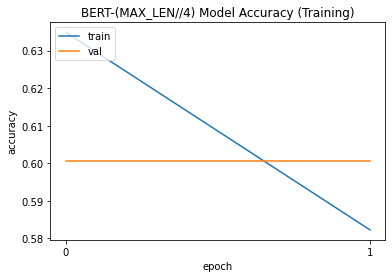

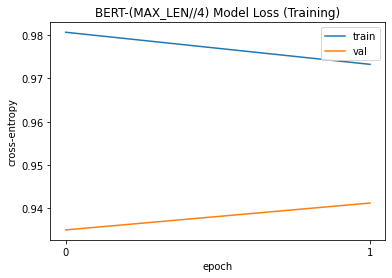

In [ ]:
plot_acc_loss_against_epoch(max_len_model_histories['model1'], 2, title1='BERT-(MAX_LEN//4) Model Accuracy (Training)', title2='BERT-(MAX_LEN//4) Model Loss (Training)')

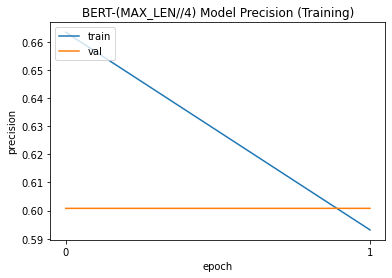

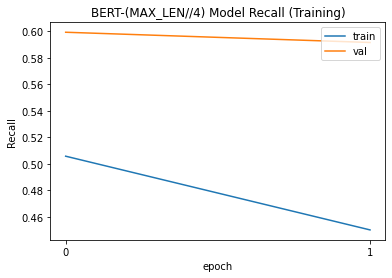

In [ ]:
plot_prec_recall_against_epoch(max_len_model_histories['model1'], max_range=2, title1='BERT-(MAX_LEN//4) Model Precision (Training)', title2='BERT-(MAX_LEN//4) Model Recall (Training)')

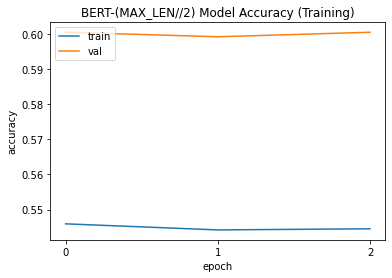

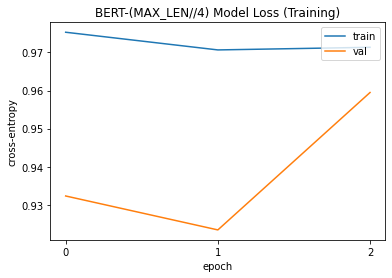

In [ ]:
plot_acc_loss_against_epoch(max_len_model_histories['model2'], 3, title1='BERT-(MAX_LEN//2) Model Accuracy (Training)', title2='BERT-(MAX_LEN//4) Model Loss (Training)')

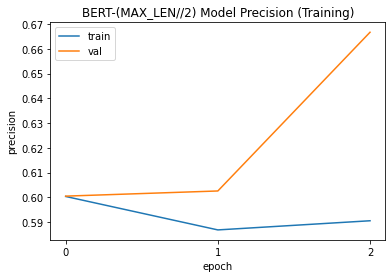

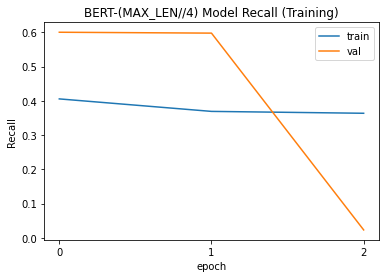

In [ ]:
plot_prec_recall_against_epoch(max_len_model_histories['model2'], max_range=3, title1='BERT-(MAX_LEN//2) Model Precision (Training)', title2='BERT-(MAX_LEN//4) Model Recall (Training)')

While reducing the max_length decreases the runtime, it worsens the model results quite significantly. Use original MAX_LEN defined.

## Effect of Learning Rate on BERT

In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 8.1 MB/s 
     |████████████████████████████████| 1.6 MB 45.7 MB/s 


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

# callbacks
checkpoint_callback = ModelCheckpoint('best_epoch', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
log_dir = "bert-tuning/fit/" + f'tuned-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def create_model_for_tuning(hp):
    hp_lr = hp.Choice('learning_rate', [5e-5, 3e-5, 2e-5, 1e-5]) # recommended lr for BERT
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model
 

In [ ]:
tuner = kt.Hyperband(create_model_for_tuning,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='',
                     overwrite=False,
                     project_name='hyperparam_tuning_for_BERT')


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# new_train_ds, new_val_ds = generate_custom_ds(32)
tuner.search(train_ds,
            epochs=10,
            validation_data=val_ds,
            callbacks=[es, checkpoint_callback, tensorboard_callback, te])

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Trial 4 Complete [00h 12m 05s]
val_loss: 0.4668329358100891

Best val_loss So Far: 0.446364164352417
Total elapsed time: 00h 48m 54s


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# reloading the best trial
trials = tuner.oracle.trials
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
learning_rate: 3e-05
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.446364164352417


In [ ]:
preds = best_model.evaluate(test_ds)
print('Updated LR Model - F1 Score on Test Data: ', f1_score(preds[2], preds[3]))

122/122 [==============================] - 29s 237ms/step - loss: 0.5073 - accuracy: 0.7979 - precision: 0.8063 - recall: 0.7856
Updated LR Model - F1 Score on Test Data:  0.7958224472539827


In [ ]:
# retraining the model on the full train & test dataset
from datetime import datetime
log_dir = "bert-newlr/fit/dropout" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

def create_updated_lr_model(dropout: bool=True):
    lr = 3e-5
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    if dropout:    
      outputs = keras.layers.Dropout(0.2)(embedded_layer)
      outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    else:
      outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)

    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model

combined_train = train_ds.concatenate(val_ds)

updated_lr_models = {}
updated_lr_model_histories = {}
names = ['with_dropout', 'without_dropout']
tes = {}
for name in names:
  tes[name] = time_for_epoch()   
  if name=='with_dropout':
    updated_lr_models[name] = create_updated_lr_model(True)
  else:
    updated_lr_models[name] = create_updated_lr_model(False)
  updated_lr_model_histories[name] = updated_lr_models[name].fit(combined_train,
                          epochs=5, # reduce number of epochs and es patience due to slower training
                          validation_data=test_ds, 
                          callbacks=[tensorboard_callback, tes[name], es]
                          )


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
485/485 [==============================] - 386s 739ms/step - loss: 0.7688 - accuracy: 0.7005 - precision: 0.7552 - recall: 0.5730 - val_loss: 0.5823 - val_accuracy: 0.7835 - val_precision: 0.8208 - val_recall: 0.7082
Epoch 2/5
485/485 [==============================] - 355s 731ms/step - loss: 0.5711 - accuracy: 0.7833 - precision: 0.8382 - recall: 0.7405 - val_loss: 0.5441 - val_accuracy: 0.8000 - val_precision: 0.8261 - val_recall: 0.7639
Epoch 3/5
485/485 [==============================] - 347s 715ms/step - loss: 0.4454 - accuracy: 0.8184 - precision: 0.8823 - recall: 0.7794 - val_loss: 0.6383 - val_accuracy: 0.8124 - val_precision: 0.8264 - val_recall: 0.7948


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
 42/485 [=>............................] - ETA: 4:39 - loss: 0.9328 - accuracy: 0.7557 - precision: 0.7878 - recall: 0.7190

In [ ]:
for name in names:
  print('Results for updated lr model ', name)
  print_all_results(updated_lr_models[name], updated_lr_model_histories[name], tes[name])
  plot_acc_loss_against_epoch(updated_lr_models[name], 5, title1='Acc Updated LR model '+name, title2='Loss for Updated LR model '+name)
  plot_prec_recall_against_epoch(updated_lr_models[name], 5, title1='Acc Updated LR model '+name, title2='Loss for Updated LR model '+name)
  print()

NameError: ignored

## Using Back-Translation to augment the data and increase the sample size for under-represented classes

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.0 MB/s 


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

In [ ]:
eng_to_de_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-de')
de_to_eng_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-de-en')

def translate(formatted_text, model, lang="de"):
  translations = model.generate(**tokenizer(formatted_text, return_tensors="pt", padding=True))
  translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translations]
  return translated_texts

def back_translate(texts, tokenizer, origin_lang="en", temp_lang="de"):
  formatted_text =  [f'>>{temp_lang}<< {text}' for text in texts]
  temp_translated_text = translate(formatted_text, eng_to_de_model, temp_lang)
  back_translated_text = translate(temp_translated_text, eng_to_de_model, origin_lang)
  return set(texts + back_translated_text)

# Squid Games Dataset

In [ ]:
sg_Xtrain = pd.read_csv('squidgame_Xtrain.csv', index_col=0)   
sg_Xtest = pd.read_csv('squidgame_Xtest.csv', index_col=0) 
sg_ytrain = pd.read_csv('squidgame_ytrain.csv', index_col=0) 
sg_ytest = pd.read_csv('squidgame_ytest.csv', index_col=0) 

# mapping the classes to a numeric representation
sg_train_labels = sg_ytrain['Class'].map({'neutral':1, 'positive': 2, 'negative': 0})
sg_test_labels = sg_ytest['Class'].map({'neutral':1, 'positive': 2, 'negative': 0})

full_X_data = pd.concat([sg_Xtrain, sg_Xtest], ignore_index=True)
full_y_data = pd.concat([sg_train_labels, sg_test_labels], ignore_index=True).values

sg_test_labels = sg_test_labels.values
# creating bert features
sg_train_input_ids, sg_train_tokens, sg_train_attention_masks = create_attention_masks(sg_Xtrain['Review'])
sg_test_input_ids, sg_test_tokens, sg_test_attention_masks = create_attention_masks(sg_Xtest['Review'])
sg_ttrain_input_ids, sg_val_input_ids, sg_ttrain_tokens, sg_val_tokens, sg_ttrain_attention_masks, sg_val_attention_masks, sg_ttrain_labels, sg_val_labels  = train_test_split(sg_train_input_ids, sg_train_tokens, sg_train_attention_masks, sg_train_labels.values, test_size=0.2)
print('Train shape: ', len(sg_ttrain_input_ids), len(sg_ttrain_tokens), len(sg_ttrain_attention_masks), len(sg_ttrain_labels))
print('Val shape: ', len(sg_val_input_ids), len(sg_val_tokens), len(sg_val_attention_masks), len(sg_val_labels))
print('Test shape: ', len(sg_test_input_ids), len(sg_test_tokens), len(sg_test_attention_masks), len(sg_test_labels))

Train shape:  758 758 758 758
Val shape:  190 190 190 190
Test shape:  237 237 237 237


In [ ]:
sg_ttrain_inputs = tf.convert_to_tensor(sg_ttrain_input_ids, dtype=tf.int32, name='input_ids')
sg_val_inputs = tf.convert_to_tensor(sg_val_input_ids, dtype=tf.int32, name='input_ids')
sg_test_inputs = tf.convert_to_tensor(sg_test_input_ids, dtype=tf.int32, name='input_ids')

sg_ttrain_tokens = tf.convert_to_tensor(sg_ttrain_tokens,dtype=tf.int32, name='token_ids')
sg_val_tokens = tf.convert_to_tensor(sg_val_tokens, dtype=tf.int32, name='token_ids')
sg_test_tokens = tf.convert_to_tensor(sg_test_tokens, dtype=tf.int32, name='token_ids')

sg_ttrain_masks = tf.convert_to_tensor(sg_ttrain_attention_masks, dtype=tf.int32, name='attention_masks')
sg_val_masks = tf.convert_to_tensor(sg_val_attention_masks, dtype=tf.int32, name='attention_masks')
sg_test_masks = tf.convert_to_tensor(sg_test_attention_masks, dtype=tf.int32, name='attention_masks')

# ttrain_labels = tf.convert_to_tensor(ttrain_labels)
# val_labels = tf.convert_to_tensor(val_labels)
# test_labels = tf.convert_to_tensor(test_labels)

sg_ttrain_labels = tf.keras.utils.to_categorical(sg_ttrain_labels, num_classes=NUM_CLASSES)
sg_val_labels = tf.keras.utils.to_categorical(sg_val_labels, num_classes=NUM_CLASSES)
sg_test_labels = tf.keras.utils.to_categorical(sg_test_labels, num_classes=NUM_CLASSES)

sg_train_ds = tf.data.Dataset.from_tensor_slices((sg_ttrain_inputs, sg_ttrain_masks, sg_ttrain_tokens, sg_ttrain_labels)).map(map_to_dict).shuffle(len(sg_ttrain_inputs)).batch(BATCH_SIZE)
sg_val_ds = tf.data.Dataset.from_tensor_slices((sg_val_inputs, sg_val_masks, sg_val_tokens, sg_val_labels)).map(map_to_dict).shuffle(len(sg_val_inputs)).batch(BATCH_SIZE)
sg_test_ds = tf.data.Dataset.from_tensor_slices((sg_test_inputs, sg_test_masks, sg_test_tokens, sg_test_labels)).map(map_to_dict).shuffle(len(sg_test_inputs)).batch(BATCH_SIZE)

 
# creating sq full ds for testing of Financial News Datasets on a different domain
full_X_data_ids, full_X_data_tokens, full_X_data_masks = create_attention_masks(full_X_data['Review'])
full_X_data_ids = tf.convert_to_tensor(full_X_data_ids, dtype=tf.int32, name='input_ids')
full_X_data_tokens = tf.convert_to_tensor(full_X_data_tokens, dtype=tf.int32, name='token_ids')
full_X_data_masks = tf.convert_to_tensor(full_X_data_masks, dtype=tf.int32, name='attention_masks')
full_y_data = tf.keras.utils.to_categorical(full_y_data, num_classes=NUM_CLASSES)
sg_full_ds = tf.data.Dataset.from_tensor_slices((full_X_data_ids, full_X_data_masks, full_X_data_tokens, full_y_data)).map(map_to_dict).shuffle(len(full_X_data_ids)).batch(BATCH_SIZE)

In [ ]:
bert_model_dropout.evaluate(sg_full_ds)

149/149 [==============================] - 32s 213ms/step - loss: 3.1122 - accuracy: 0.0532 - precision: 0.0532 - recall: 0.0532


[3.1122281551361084,
 0.05316455662250519,
 0.05316455662250519,
 0.05316455662250519]

In [ ]:
print('F1 Score on a different domain: ', f1_score())